In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import paths

import importlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import ecco_v4_py as ecco

from streamfunction_ecco import streamfunction_ecco_utils as strf_ecco_utils
from streamfunction_ecco import streamfunction_custom_utils as strf_custom_utils

In [4]:
importlib.reload(paths)

<module 'paths' from 'C:\\Users\\aline\\OTP\\paths.py'>

In [5]:
# Load the data and the native geometry grid 
ecco_grid = xr.open_dataset(paths.geom_fp)
ecco_grid

<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 ...
    Zu       (k_u) float32 ...
    Zl       (k_l) float32 ...
    XC_bnds  (tile, j, i, nb) float32 ...
    YC_bnds  (tile, j, i, nb) float32 ...
    Z_bnds   (k, nv) float32 ...
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 ...
    SN       (tile, j, i) float32 ...
    rA       (tile, j, i) float32 ...
    dxG      (tile, j_g, i) float32 ...
    dyG      (tile, j, i_g) float32 ...
    Depth    (tile, j, i) float32 ...
    ...       ...
    hFacC    (k, tile, j, i) float32 ...
    hFacW    (k, tile, j, i_g) float32 ...
    hFacS    (k, tile, j_g, i) float32 ...
    maskC    (k, tile, j, i) bool ...
    maskW    (k, tile, j, i_g) bool ...
    maskS    (k, tile, j_g, i) bool ...
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

In [6]:
OUTPUT_DIR = paths.STREAMFUNCTIONS_ECCO_OUTPUT

PSI_26 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_residual26.5N.nc"))
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_bolus26.5N.nc")))
PSI_30 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_residual30S.nc")) 
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_bolus30S.nc")))
PSI_55 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_residual55S.nc")) 
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_bolus55S.nc")))
PSI_60 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_residual60S.nc")) 
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_bolus60S.nc")))

In [7]:
def plot(PSI, PSI_bol=None):# Streamfunction over depth and time
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, (1, 3))
    plt.pcolormesh(PSI.time, PSI.Z, PSI.psi_moc.squeeze().T)
    if PSI_bol is not None:
        plt.pcolormesh(PSI.time, PSI.Z, PSI.psi_moc.squeeze().T+PSI_bol.psi_moc.squeeze().T)
    plt.colorbar()
    plt.ylabel('Depth [m]')
    
    plt.subplot(1, 4, 4)
    plt.plot(PSI['psi_moc'].isel(time=2), PSI["Z"], 
             color='green', label='Residual Mean')#.mean("time")
    if PSI_bol is not None:
        plt.plot(PSI_bol['psi_moc'].mean("time"), PSI_bol["Z"], 
                 linestyle='--', color='green', label='Bolus mean')
        plt.plot(PSI_bol['psi_moc'].mean("time")+PSI['psi_moc'].mean("time"), PSI_bol["Z"],
                 linestyle='-', color='blue', label='Sum mean')
    plt.ylabel("Depth [m]")
    plt.xlabel("[Sv]")
    plt.grid()
    plt.legend()
    plt.show()

In [21]:
PSI = PSI_26
num_years = len(PSI['time']) // 12
yearly_averages = np.array([PSI['psi_moc'].isel(time=slice(i*12, (i+1)*12)).mean(dim='time') for i in range(num_years)])

In [22]:
yearly_averages

array([[[ 1.35677812],
        [ 6.88675779],
        [ 8.77452029],
        ...,
        [-0.32583276],
        [-0.0718407 ],
        [ 0.08747863]],

       [[ 1.42635825],
        [ 6.55999558],
        [ 8.15963195],
        ...,
        [-0.58549767],
        [-0.29668646],
        [ 0.11032619]],

       [[ 0.92941498],
        [ 5.30795661],
        [ 7.46584132],
        ...,
        [-0.5704865 ],
        [-0.29815291],
        [ 0.11943243]],

       ...,

       [[ 1.18868685],
        [ 6.08536193],
        [ 8.19406187],
        ...,
        [-0.40823221],
        [ 0.06063604],
        [ 0.13828852]],

       [[ 1.50007174],
        [ 5.89426577],
        [ 8.07803119],
        ...,
        [-0.46735075],
        [-0.0390218 ],
        [ 0.10156908]],

       [[ 1.2243466 ],
        [ 6.91823234],
        [ 8.70617088],
        ...,
        [-1.08081861],
        [-0.28859119],
        [ 0.0540128 ]]])

In [20]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# Setup figure and axes for the plot
fig, ax = plt.subplots(figsize=(4, 4))

PSI = yearly_averages

line, = ax.plot(PSI['psi_moc'].isel(time=0), PSI['Z'], color='green', label='Residual Mean')
ax.set_xlim([PSI['psi_moc'].min(), PSI['psi_moc'].max()])  # Adjust x-axis limits
ax.set_ylim([PSI['Z'].min()-200, PSI['Z'].max()+200]) 
ax.set_ylabel("Depth [m]")
ax.set_xlabel("[Sv]")
ax.grid()
ax.legend()

title = ax.set_title('Time step: 0')

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    title.set_text('')
    return line, title

# Update function for the animation, which includes updating the title
def update(frame):
    # Update the data for the line plot
    line.set_data(PSI['psi_moc'].isel(time=frame), PSI['Z'])
    
    # Update the title to reflect the current time step or any other parameter
    title.set_text(f'Time step: {frame}')
    
    return line, title

# Number of frames (assuming 312 time steps, adjust as necessary)
num_frames = len(PSI['time'])

# Create the animation
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=True)

# Save the animation
ani.save('moc_animation.mp4', writer='ffmpeg', fps=10)

# Display the animation in the notebook (optional, requires IPython.display.Video)
from IPython.display import Video
Video('moc_animation.mp4')

<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [19]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import xarray as xr

PSI = PSI_26

# Setup figure
fig, ax = plt.subplots(figsize=(4,4))
line, = ax.plot([], [], color='green', label='Residual Mean')
ax.set_xlim([PSI['psi_moc'].min(), PSI['psi_moc'].max()])  # Adjust x-axis limits
ax.set_ylim([PSI['k'].min()-2, PSI['k'].max()+2]) 
ax.set_ylabel("Depth [m]")
ax.set_xlabel("[Sv]")
ax.grid()
ax.legend()

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# Animation update function
def update(frame):
    y_data = PSI['psi_moc'].isel(time=frame)
    line.set_data(y_data, PSI["k"])
    return (line,)

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, 313),
                    init_func=init, blit=True)

plt.show()


<IPython.core.display.Javascript object>

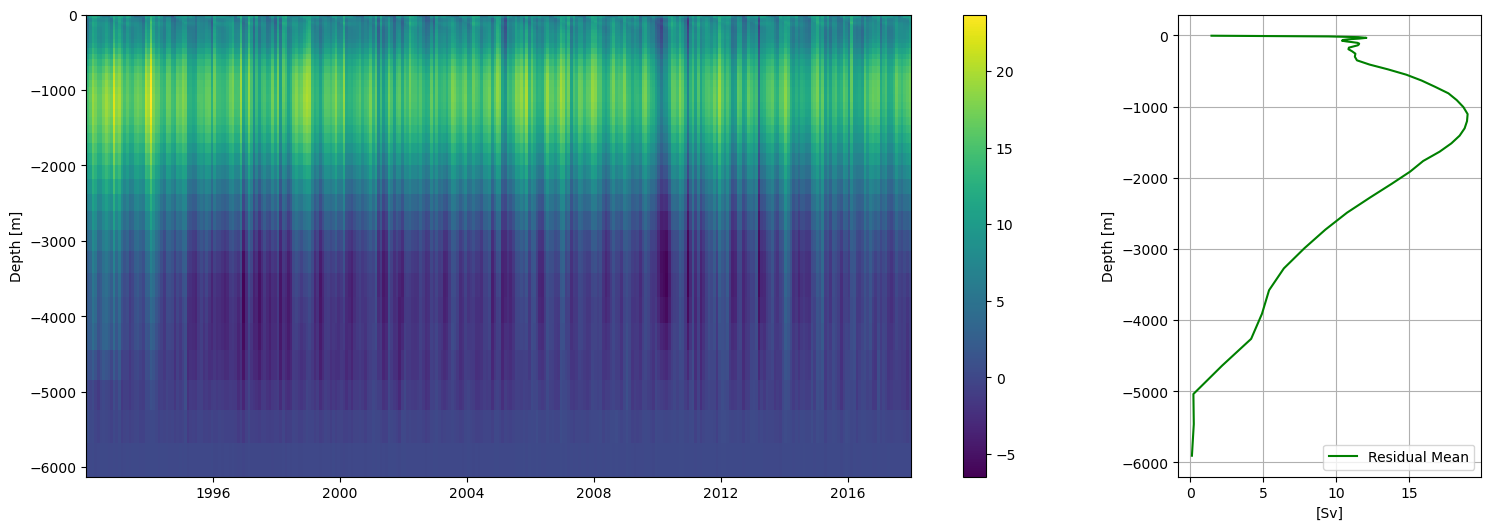

In [62]:
plot(PSI_26)

In [27]:
max_indices = PSI_26['psi_moc'].argmax(dim='k')
depth_max_values = ecco_grid['Z'].isel(k=max_indices)
PSI_26['depth_max'] = depth_max_values

min_indices = PSI_26['psi_moc'].argmin(dim='k')
depth_min_values = ecco_grid['Z'].isel(k=min_indices)
PSI_26['depth_min'] = depth_min_values

In [56]:
zero_crossing_depths = xr.full_like(PSI_26['time'], fill_value=np.nan)
    
# Iterate over each timestep
for time in range(len(PSI_26['time'].values)):
    # Get the max and min indices for the current timestep
    max_idx = max_indices[time].item()
    min_idx = min_indices[time].item()
    
    print(min_idx, max_idx)
    
    # Slice the psi_moc values between max_idx and min_idx
    psi_moc_slice = PSI_26['psi_moc'][time, min(min_idx, max_idx):max(min_idx,max_idx)]
        
    # Adjust logic here if multiple crossings can occur or if more complex handling is needed.
    signs = np.sign(psi_moc_slice)
    
    print(signs)
        
    # Check if a crossing was found
    if len(cross_idx) > 0:
        # Assuming the first crossing is the desired one
        crossing_index = cross_idx[0] + min_idx  # Adjust index relative to the full dataset
            
        # Assign the corresponding depth value
        zero_crossing_depths[t] = ecco_grid['Z'][crossing_index]
    
# Assign the zero-crossing depths to PSI_26
PSI_26['zero_crossing_depth'] = ('time', zero_crossing_depths)

47 29
<xarray.DataArray 'psi_moc' (k: 18, lat: 1)>
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])
Coordinates:
    Z        (k) float32 -1.106e+03 -1.206e+03 ... -4.264e+03 -4.64e+03
  * k        (k) int32 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
  * lat      (lat) float64 26.5
    time     datetime64[ns] 1992-01-16T18:00:00


IndexError: arrays used as indices must be of integer (or boolean) type

In [26]:
signs = np.sign(PSI_26['psi_moc'])
sign_changes = signs.diff(dim='k')

change_indices = np.where(sign_changes != 0, 1, 0)
change_indices

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [1]]])

In [20]:
psi_data = PSI_26

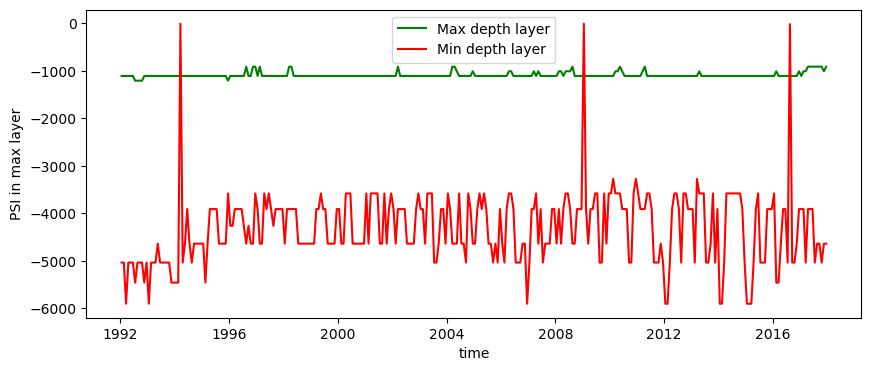

In [22]:
plt.figure(figsize = (10, 4))
plt.plot(psi_data["time"], psi_data["depth_max"], color='green', label='Max depth layer')
plt.plot(psi_data["time"], psi_data["depth_min"], color='red', label='Min depth layer')

plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()
plt.show()

In [5]:
PSI_MAX_DENS_26 = strf_custom_utils.get_PSI_at_max_density_level(PSI_26, max=False)
PSI_MAX_DENS_30 = strf_custom_utils.get_PSI_at_max_density_level(PSI_30, max=True)
PSI_MAX_DENS_55 = strf_custom_utils.get_PSI_at_max_density_level(PSI_55, max=True)
PSI_MAX_DENS_60 = strf_custom_utils.get_PSI_at_max_density_level(PSI_60, max=True)